In [1]:
import numpy as np
import batman

from lmfit import Parameters, minimize

In [2]:
def transit_model(x, epo, per, rprs, ars, b, u1, u2):
    '''
    Calculates transit model using batman
    INPUT:
        x - array of times to calculate model on (days)
        epo - epoch (days)
        per - orbital period (days)
        rprs - planet radius divided by stellar radius
        ars - distance from planet to star divided by stellar radius
        b - impact parameter
        u1 - first quadratic limb darkening parameter
        u2 - second quadratic limb darkening parameter
    OUTPUT: array of model fluxes
    '''
    bparams = batman.TransitParams()
    bparams.t0 = epo
    bparams.per = per
    bparams.rp = rprs
    bparams.a = ars
    bparams.inc = np.arccos(b/ars)*180./np.pi
    bparams.ecc = 0.
    bparams.w = 90.
    bparams.u = [u1, u2]
    bparams.limb_dark = "quadratic"
    m = batman.TransitModel(bparams, x)
    model = m.light_curve(bparams)
    return model

def residual(params, x, y, yerr):
    '''
    Calculates residual between observations and model
    INPUT:
        params - collection of lmfit parameters
        x - array of times (days)
        y - array of observed fluxes
        yerr - array of uncertainties in observed fluxes
    OUTPUT: difference between observed flux and modeled flux
    '''
    epo = params['epo']
    per = params['per']
    rprs = params['rprs']
    b = params['b']
    ars = params['ars']
    u1 = params['u1']
    u2 = params['u2']
    model = transit_model(x, epo, per, rprs, ars, b, u1, u2)
    return np.sqrt((y - model)**2./yerr**2)

def fit_transit_model(x, y, yerr, epo, per, rprs, dur, u1, u2, cap_b=True, fit_u=False):
    '''
    Fits transit model to data
    INPUT:
        x - array of times (days)
        y - array of observed fluxes
        epo - epoch (days)
        per - orbital period (days)
        rprs - planet radius divided by stellar radius
        dur - transit duration (days)
        u1 - first quadratic limb darkening parameter
        u2 - second quadratic limb darkening parameter
        cap_b - True if you want impact parameter within [0, 1];
                False if you want impact parameter within [0, 1 + rprs]
        fit_u - True if you want to fit limb darkening parameters; False if not
    OUTPUT: lmfit best-fit results
    '''    
    best_chisqr = np.inf
    # Due to degeneracies in fit parameters, try initial fits with b fixed
    for b in [0.1, 0.3, 0.5, 0.7, 0.9]:
        # Estimate ars from transit duration and impact parameter
        nom = (1. + rprs)**2. - b**2. * (1. - np.sin(dur*np.pi/per)**2.)
        denom = np.sin(dur*np.pi/per)**2.
        ars = np.sqrt(nom/denom)
        params = Parameters()
        params.add('per', value=per, min=0)
        params.add('epo', value=epo, min=0)
        if cap_b:
            params.add('b', value=b, min=0, max=1, vary=False)
            params.add('rprs', value=rprs, min=0, max=1)
        else:
            params.add('b', value=b, min=0, vary=False)
            params.add('delta', value=b-rprs, max=1)
            params.add('rprs', expr='b - delta')
        params.add('ars', value=ars, min=0)
        if fit_u:
            params.add('u1', value=u1)
            params.add('u2', value=u2)
        else:
            params.add('u1', value=u1, vary=False)
            params.add('u2', value=u2, vary=False)            
        out = minimize(residual, params, args=(x, y, yerr))
        chisqr = out.chisqr
        if chisqr < best_chisqr:
            best_b = b
            best_out = out
            best_chisqr = chisqr
    # Now do a full fit, allowing b to vary
    best_out.params['b'].vary = True
    final_out = minimize(residual, best_out.params, args=(x, y, yerr))
    return final_out

In [3]:
import lightkurve as lk
import matplotlib.pyplot as plt

lcfs = lk.search_lightcurve("TIC 158588995", mission="TESS", author="QLP").download_all()
lc = lcfs.stitch()

time = lc['time'].value
qflag = lc['quality'].value
flux = lc['kspsap_flux'].value

good = (qflag == 0) & ~np.isnan(flux)

time = time[good]
flux = flux[good]

mad = np.nanmedian(np.abs(flux - np.nanmedian(flux)))
flux_err = 1.48*mad*np.ones(len(flux))

Text(0, 0.5, 'Normalized Flux')

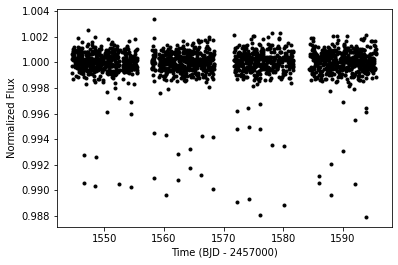

In [4]:
plt.plot(time, flux, "k.")
plt.xlabel("Time (BJD - 2457000)")
plt.ylabel("Normalized Flux")

In [5]:
# Get initial model guesses from BLS
guess_epo = 1641.404552
guess_per = 1.977143
guess_dep = 0.0144563
guess_dur_hrs = 1.0553

guess_dur = guess_dur_hrs/24.
guess_rprs = np.sqrt(guess_dep)

# Limb-darkening from Claret (2017)
guess_u1 = 0.1555
guess_u2 = 0.4459

In [6]:
# Fit transit model

# OPTIONAL: only fit data within 2 transit duration (speeds up fit):
phase = (time - guess_epo) % guess_per
phase[phase > 0.5*guess_per] -= guess_per
near_transit = (abs(phase) < 2.*guess_dur)

x = time[near_transit]
y = flux[near_transit]
yerr = flux_err[near_transit]

In [7]:
# Fit transit model. The default is to force b to vary between [0,1], and to not fit limb darkening parameters
best_fit = fit_transit_model(x, y, yerr, guess_epo, guess_per, guess_rprs, guess_dur, guess_u1, guess_u2)

best_fit

Text(0, 0.5, 'Relative flux')

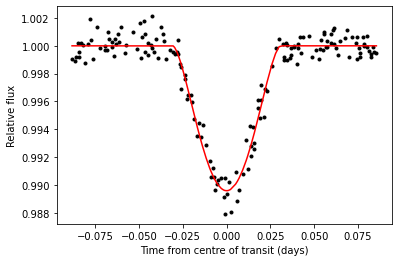

In [8]:
# Plot best-fit result

best_epo = best_fit.params["epo"]
best_per = best_fit.params["per"]
best_rprs = best_fit.params["rprs"]
best_ars = best_fit.params["ars"]
best_b = best_fit.params["b"]
best_u1 = best_fit.params["u1"]
best_u2 = best_fit.params["u2"]

phase = (x - best_epo) % best_per
phase[phase > 0.5*best_per] -= best_per
idx_sort = np.argsort(phase)

model = transit_model(x, best_epo, best_per, best_rprs, best_ars, best_b, best_u1, best_u2)

plt.plot(phase, y, "k.")
plt.plot(phase[idx_sort], model[idx_sort], "r")
plt.xlabel("Time from centre of transit (days)")
plt.ylabel("Relative flux")